In [167]:
# RNN :  가중치를 반복해 사용하는 시계열 데이터를 다루는 모델 - 시간의 순서가 포함
# MinMaxScale : 최대-최소 정규화 - 최대값이 1이 되로고 값의 범위를 바꿔주는 기법, 이상치가 없는 데이터에 사용

In [168]:
# 모델 : 과거정보와 현재 정보를 둘 다 갖고 있어야 함,-> 모델이 내보낸 과거의 출력을 다시 입력으로 넣어줘야함
# recurrent  
# 순환하는 인공신경망 RNN(Recurrent neural network)

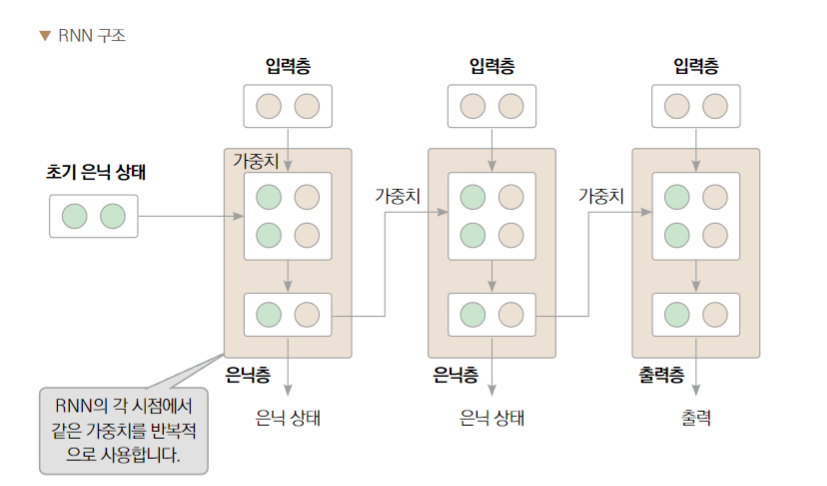

In [169]:
# 장점
# 이전 정보를 현재 시점에서 사용, 시간에 대한 정보를 추출
# 같은 가중치를 반복 사용하기 때문에 가중치 수가 적다

# 단점
# 같은 가중치를 반복 사용하기 때문에 계산에 오래걸린다
# 시계열이 길어질수록 앞의 정보가 점점 흐려진다.

In [170]:
import pandas as pd

In [171]:
data = pd.read_csv("./train.csv")
data.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


In [173]:
import matplotlib.pyplot as plt

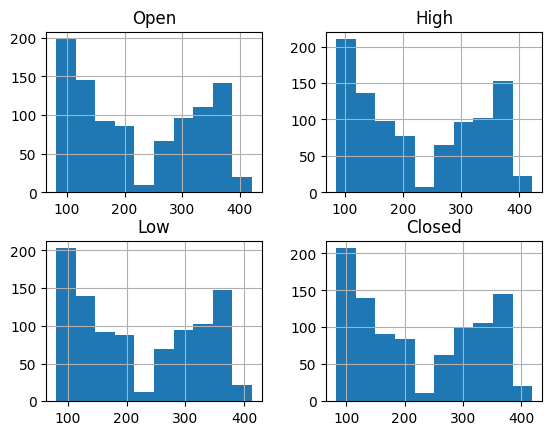

In [174]:
data_used = data.iloc[:, 1:4]
data_used['Closed'] = data['Close']
hist = data_used.hist()
plt.show()

In [175]:
# 딥러닝 오차값을 이용해서 역전파로 가중치를 업데이트, 데이터의 범위가 넗으면.. 기울기도 커진다.
# 0과 1사이로 정규화
data_used.describe()

,Open,High,Low,Closed
count,967.000000,967.000000,967.000000,967.000000
mean,223.923475,227.154085,220.323681,223.827301
std,104.455030,106.028484,102.549658,104.319356
min,81.000000,85.000000,80.000000,83.000000
25%,124.000000,126.000000,123.000000,124.000000
50%,194.000000,196.000000,192.000000,194.000000
75%,329.000000,332.000000,323.000000,327.500000
max,421.000000,423.000000,413.000000,419.000000


In [176]:
# 학습용 데이터
# window size 30일치 
import numpy as np
from torch.utils.data.dataset import Dataset

In [177]:
class AAA(Dataset):
  def __init__(self):
    pass
  def __len__(self):
    return 100

In [178]:
aaa = AAA()
len(aaa)

100

In [179]:
class Netflix(Dataset):
  def __init__(self) -> None:
    self.csv = pd.read_csv('./train.csv')
    self.data = self.csv.iloc[:,1:4].values # 주의 데이터 프레임 형태면 안됨
    self.data = self.data / np.max(self.data)

    self.label = data['Close'].values
    self.label = self.label / np.max(self.label)

  # 사용가능한 배치리턴
  def __len__(self):    
    return len(self.data) - 30

  def __getitem__(self, i):
    data = self.data[i:i+30]
    label = self.label[i+30]
    return data, label

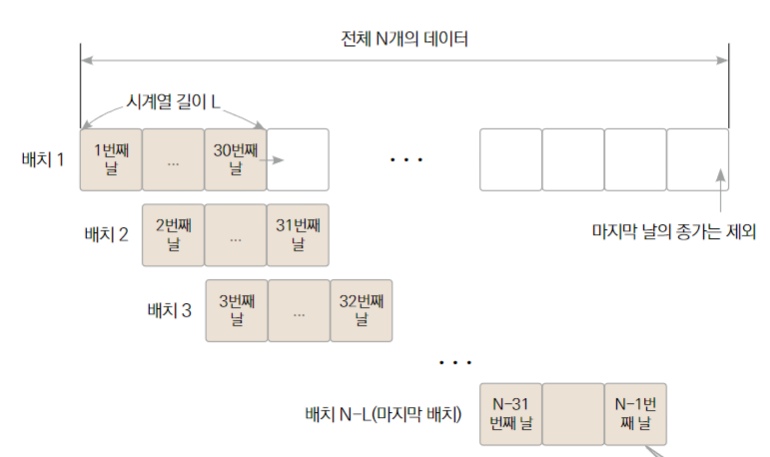

In [180]:
# 모델 정의
# RNN 층을 여러개 쌓아서 시계열 정보에서 특징추출 ,MLP층을 쌓아서 예측


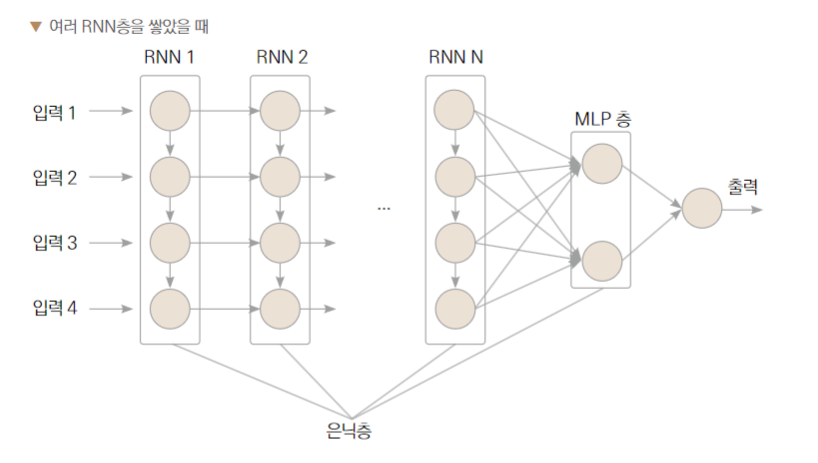

In [181]:
import torch
import torch.nn as nn

In [182]:
class RNN(nn.Module):
  def __init__(self) -> None:
    super(RNN,self).__init__()
    # RNN 층
    self.rnn = nn.RNN(input_size = 3, hidden_size=8, num_layers=5, batch_first=True)

    # MLP층
    self.fc1 = nn.Linear(in_features = 240, out_features=64)
    self.fc2 = nn.Linear(in_features = 64, out_features=1)

    self.relu = nn.ReLU()
  def forward(self,x,h0):
    x,hn = self.rnn(x,h0);      # 첫번째출력: 마지막 RNN층의 은닉상태, 두번째출력:모든 RNN층의 은닉상태를 반환
    # MLP층의 입력으로 사용되도록 모양을 변경
    x = torch.reshape(x, (x.shape[0],-1))

    #MLP층을 이용해 종가 예측
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    # 예측한 종가를 1차원 벡터로 표현
    x = torch.flatten(x)

    return x


In [183]:
import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RNN().to(device)
dataset = Netflix()
dataloader = DataLoader(dataset,batch_size=32)

In [184]:
optim = Adam(model.parameters(), lr = 1e-4)

In [185]:
for epoch in range(200):
  iter = tqdm.tqdm(dataloader)
  for data,label in iter:
    optim.zero_grad()
    # 초기 은닉상태
    h0 = torch.zeros(5,data.shape[0], 8).to(device)  # (5 ,32, 8)
    # 예측값
    pred = model(data.type(torch.FloatTensor).to(device), h0 )
    # 손실의 계산
    loss = nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device))
    loss.backward()
    optim.step()
    iter.set_description(f"epoch{epoch} loss:{loss.item()}")

epoch199 loss:0.00046431872760877013: 100%|██████████| 30/30 [00:00<00:00, 114.24it/s]


In [186]:
torch.save(model.state_dict(),'./rnn.pth')

In [187]:
# 모델 평가
loader = DataLoader(dataset, batch_size=1) # 예측값을 위한 데이터 로드
preds = []
total_loss = 0
with torch.no_grad():
  model.load_state_dict(torch.load('./rnn.pth', map_location=device))
  for data, label in loader:
    h0 = torch.zeros(5, data.shape[0],8).to(device)
    # 예측값 출력
    pred = model(data.type(torch.FloatTensor).to(device), h0)
    preds.append(pred.item())
    # 손실 계산
    loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
    # 손실의 평균치 계산
    total_loss += loss/len(loader)

In [188]:
total_loss.item()

0.001075791660696268

In [189]:
len(preds)

937

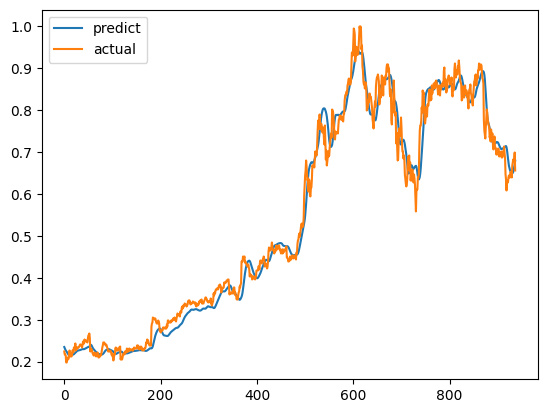

In [190]:
plt.plot(preds, label = 'predict')
plt.plot(dataset.label[30:], label='actual')
plt.legend()
plt.show()